In [395]:
using NCDatasets
using FileIO
using Statistics
using DelimitedFiles
using Plots
using Printf

In [86]:
#save_σ_hr()

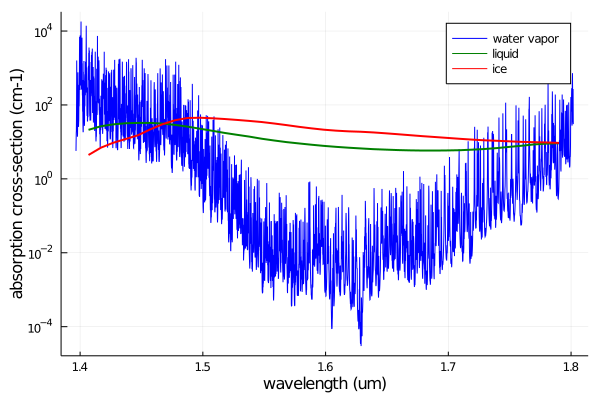

In [402]:
include("helper.jl")

hyp_wl, rad = read_Hyperion();
ν, k1 = make_vapor_xsection();
k2, k3 = read_Kuo_abs(hyp_wl);

plot_cross_sections(ν, k1, hyp_wl, k2, k3)

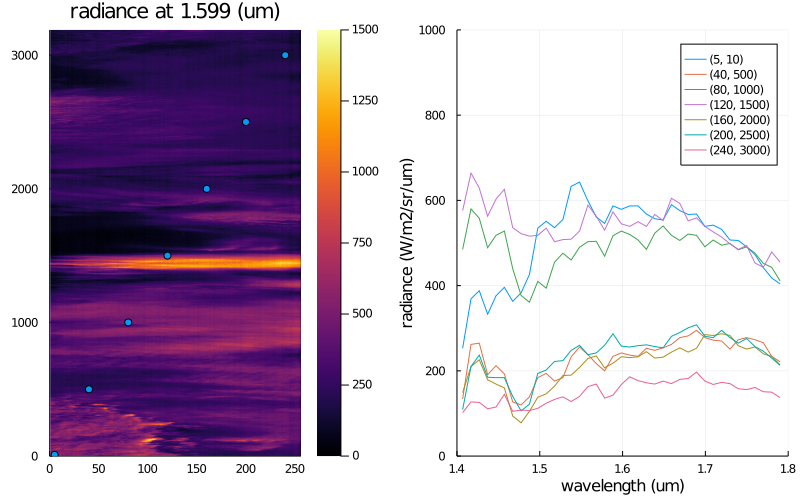

In [409]:
include("helper.jl")
plot_radiances(hyp_wl, rad)

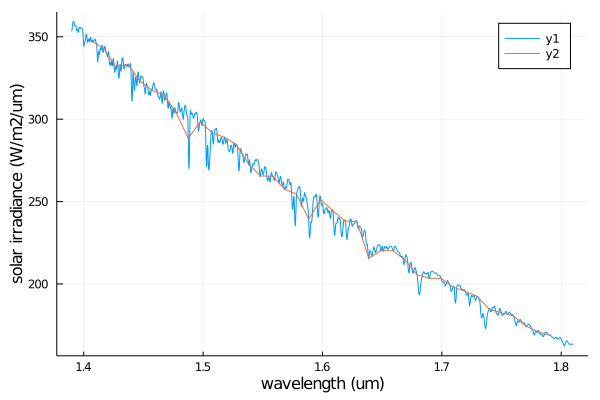

In [410]:
ds = readdlm("solar-visie.tsv",'\t',skipstart=35)
wl_hr = ds[:,1];
solar_hr = ds[:,2] .* 1e3;
hyp = KernelInstrument(gaussian_kernel(0.001, 0.005), hyp_wl .* 1e3);
Fsolar = conv_spectra(hyp, wl_hr[1]:wl_hr[2]-wl_hr[1]:wl_hr[end], solar_hr);
wl_hr /= 1e3;

plot(wl_hr, tsolar_hr)
plot!(hyp_wl, Fsolar)
xlabel!("wavelength (um)")
ylabel!("solar irradiance (W/m2/um)")

In [411]:
using Insolation
using Dates

lat, lon = -77.528, 167.164 
tz = 13.0
date = DateTime(2005,12,16,13,27,21)
θ,d = Insolation.ZenithAngleCalc.instantaneous_zenith_angle(date, tz, lon, lat)
println(rad2deg(θ))
cosθ = cos(θ)
println(cosθ)

54.25184734115209
0.5842234984148752


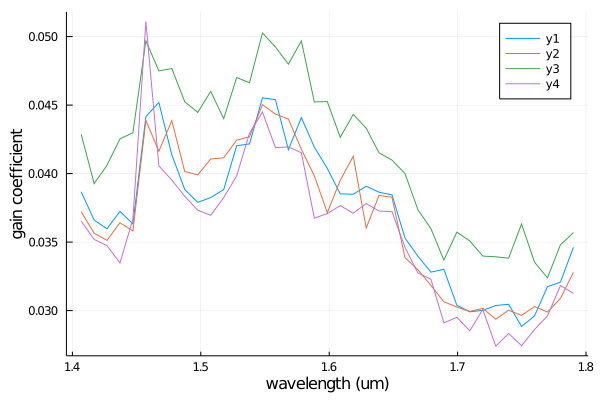

10.94409
242 0.10402593
256 0.3699023


In [412]:
entity_id = "EO1H2221282005350110KF";
file = "../EO1_Hyperion_data/"*entity_id*"/"*entity_id*".AUX";
ds = Dataset(file);
bandwidth = ds["Spectral Bandwidths"][:];
gain = ds["Gain Coefficients"][:];
λ = mean(ds["Spectral Center Wavelengths"][:], dims=1)[1,:] * 1e-3;
wlrange = findall(x -> x > 1.4 && x < 1.8, λ);

gain = gain[:,wlrange];
λ = λ[wlrange];

p = plot(λ, gain[1,:])
plot!(λ, gain[10,:])
plot!(λ, gain[100,:])
plot!(λ, gain[256,:])
xlabel!("wavelength (um)")
ylabel!("gain coefficient")
display(p)
    
println(mean(bandwidth))
println(length(std(bandwidth, dims=1))," ", mean(std(bandwidth, dims=1)))
println(length(std(bandwidth, dims=2))," ", mean(std(bandwidth, dims=2)))

In [415]:
include("helper.jl")

hyp_wl, rad = read_Hyperion();
ν_hr, k1_hr = make_vapor_xsection();
hyp = KernelInstrument(gaussian_kernel(10, 0.005), 1e4 ./ hyp_wl);
k1 = conv_spectra(hyp, ν, k1_hr);
k2, k3 = read_Kuo_abs(hyp_wl);

In [475]:
# function fwd_model(x; λ=hyp_wl, k1=k1, k2=k2, k3=k3)
#     l, m, u1, u2, u3 = x;
#     logρ = l .+ λ*m .- k1*u1 .- k2*u2 .- k3*u3;
#     ρ = exp.(logρ);
#     return ρ
# end

function fwd_model(x; instrument=hyp, λ=hyp_wl, ν_hr=ν_hr, k1_hr=k1_hr, k2=k2, k3=k3)
    l, m, u1, u2, u3 = x;
    T0 = exp.(l .+ λ*m);
    T1_hr = exp.(-k1_hr*u1);
    T1_conv = conv_spectra(instrument, ν_hr, T1_hr);
    T23 = exp.(-k2*u2 .- k3*u3);
    ρ = T0 .* T1_conv .* T23;
    return ρ
end

function run_fit(y; λ=hyp_wl, k1=k1, k2=k2, k3=k3)
    K = [ones(length(λ)) λ -k1 -k2 -k3];
    
    # Construct error covariance matrix
    noise = 1/100;
    Se = Diagonal((ones(length(λ)).*noise).^2);
    
    # Solve normal equations:
    x̂ = inv(K'inv(Se)K) * K'inv(Se) * log.(y);
    
    return x̂
end

run_fit (generic function with 1 method)

In [476]:
function fwd_model_FWHM(x; λ=hyp_wl, ν_hr=ν_hr, k1_hr=k1_hr, k2=k2, k3=k3)
    l, m, u1, u2, u3, FWHM = x;
    T1 = exp.(l .+ λ*m .- k2*u2 .- k3*u3);
    T2_hr = exp.(-k1_hr*u1);
    instrument = KernelInstrument(gaussian_kernel(FWHM, 0.005), 1e4 ./ hyp_wl);
    T2_conv = conv_spectra(instrument, ν_hr, T2_hr);
    ρ = T1 .* T2_conv;
    return ρ
end

function run_fit_FWHM(y; λ=hyp_wl, k1=k1, k2=k2, k3=k3)
    K = [ones(length(λ)) λ -k1 -k2 -k3 ones(length(λ))];
    
    # Construct error covariance matrix
    noise = 1/100;
    Se = Diagonal((ones(length(λ)).*noise).^2);
    
    # Solve normal equations:
    x̂ = inv(K'inv(Se)K) * K'inv(Se) * log.(y);
    
    return x̂
end

run_fit_FWHM (generic function with 1 method)

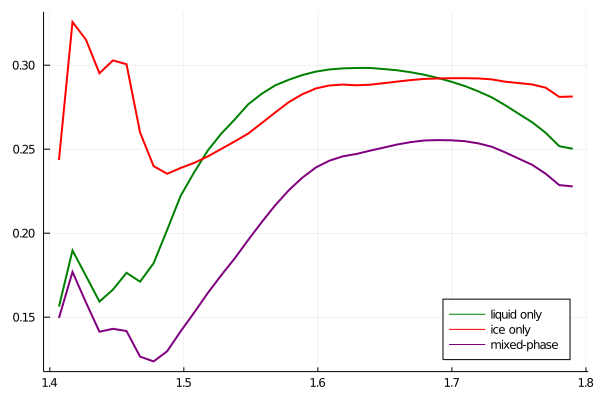

In [479]:
xliq = [-0.014, -0.64, 1.12e16, 0.023, 0];
xice = [-0.014, -0.64, 1.12e16, 0, 0.01];
xmixed = [-0.014, -0.64, 1.12e16, 0.023, 0.01];
plot(hyp_wl, fwd_model(xliq), color=:green, lw=2, label="liquid only", legend=:bottomright)
plot!(hyp_wl, fwd_model(xice), color=:red, lw=2, label="ice only")
plot!(hyp_wl, fwd_model(xmixed), color=:purple, lw=2, label="mixed-phase")

liquid, ice
[0.023565910537567184, 0.012330616227170963]


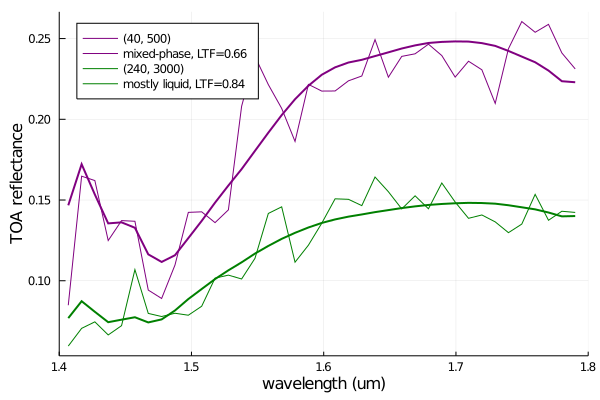

[0.020979942390351315, 0.004117746063975215]


In [486]:
(i,j) = (40,500);
ρ = rad[i,:,j] .* gain[i,:] .* π ./ cosθ ./ Fsolar;
p = plot(hyp_wl, ρ, color=:purple, label="("*string(i)*", "*string(j)*")");
x̂ = run_fit(ρ);
println("liquid, ice")
println(x̂[4:end])
LTF = x̂[4] / (x̂[4] + x̂[5]);
plot!(hyp_wl, fwd_model(x̂), color=:purple, lw=2, label="mixed-phase, "*@sprintf("LTF=%.2f",LTF));

(i,j) = (240,3000);
ρ = rad[i,:,j] .* gain[i,:] .* π ./ cosθ ./ Fsolar;
plot!(hyp_wl, ρ, color=:green, label="("*string(i)*", "*string(j)*")");
x̂ = run_fit(ρ);
LTF = x̂[4] / (x̂[4] + x̂[5]);
println(x̂[4:end])
plot!(hyp_wl, fwd_model(x̂), color=:green, lw=2, label="mostly liquid, "*@sprintf("LTF=%.2f",LTF), legend=:topleft);

xlims!(1.4,1.8)
xlabel!("wavelength (um)")
ylabel!("TOA reflectance")
savefig(p, "./figures/rho_fit.png")
display(p)

In [487]:
(i,j) = (40,500);
y = rad[i,:,j] .* gain[i,:] .* π ./ cosθ ./ Fsolar;
x̂ = run_fit(y);
LTF = x̂[4] / (x̂[4] + x̂[5]);

p1 = plot(hyp_wl, y, label="measured", legend=:bottomright);
plot!(hyp_wl, fwd_model(x̂), label="modeled");
ylabel!("TOA reflectance");
ylims!(0,0.3)
title!(@sprintf("LTF=%.2f",LTF))

instrument = KernelInstrument(gaussian_kernel(10, 0.005), 1e4 ./ hyp_wl);
Tvapor_hr = exp.(-k1_hr*x̂[3]);
Tvapor_conv = conv_spectra(instrument, ν_hr, Tvapor_hr);
p3 = plot(hyp_wl, Tvapor_conv, color=:blue, label="water vapor", legend=:bottomright);
plot!(hyp_wl, exp.(-x̂[4]*k2), color=:green, label="liquid");
plot!(hyp_wl, exp.(-x̂[5]*k3), color=:red, label="ice");
ylabel!("transmittance")
ylims!(0,1)

p5 = plot(hyp_wl, fwd_model(x̂) - y, color=2, label="");
plot!(hyp_wl, zeros(length(hyp_wl)), color=:black, label="");
xlabel!("wavelength (um)");
ylabel!("residual");
ylims!(-0.1,0.1)

(i,j) = (240,3000);
y = rad[i,:,j] .* gain[i,:] .* π ./ cosθ ./ Fsolar;
x̂ = run_fit(y);
LTF = x̂[4] / (x̂[4] + x̂[5]);

p2 = plot(hyp_wl, y, label="");
plot!(hyp_wl, fwd_model(x̂), label="");
ylims!(0,0.3)
title!(@sprintf("LTF=%.2f",LTF))

p4 = plot(hyp_wl, exp.(-x̂[3]*k1), color=:blue, label="");
plot!(hyp_wl, exp.(-x̂[4]*k2), color=:green, label="");
plot!(hyp_wl, exp.(-x̂[5]*k3), color=:red, label="");
ylims!(0,1)

p6 = plot(hyp_wl, fwd_model(x̂) - y, color=2, label="");
plot!(hyp_wl, zeros(length(hyp_wl)), color=:black, label="");
xlabel!("wavelength (um)");
ylims!(-0.1,0.1)

p = plot(p1,p2,p3,p4,p5,p6,layout=(3,2),size=(700,500))
savefig(p, "./figures/rho_transmittance_residual.png")

In [489]:
LTFarr = zeros(256,3189);
for i=1:256, j=1:3189
    ρ = rad[i,:,j] .* gain[i,:] .* π ./ cosθ ./ Fsolar;
    if minimum(ρ) > 0
        x̂ = run_fit(ρ);
        LTFarr[i,j] = x̂[4] / (x̂[4] + x̂[5]);
    else
        LTFarr[i,j] = NaN
    end
end

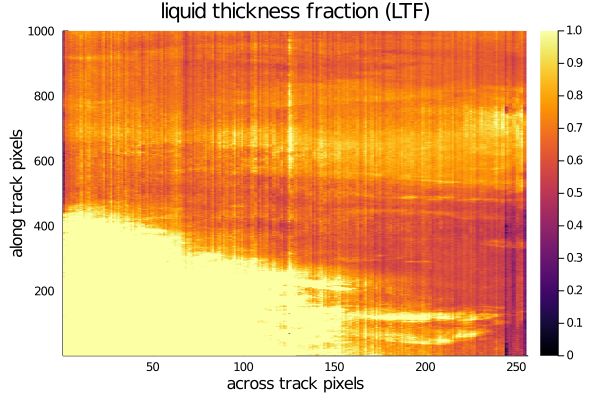

In [492]:
p = heatmap(LTFarr[:,1:1000]', clim=(0,1))
title!("liquid thickness fraction (LTF)")
xlabel!("across track pixels")
ylabel!("along track pixels")
savefig(p, "./figures/LTFmap.png")
display(p)